In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

%matplotlib inline 

In [3]:
%%time
may_trip = pd.read_csv('../data/may_trip.csv')
may_trip.head()

Wall time: 5.63 s


,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt
0,2019-05-01 00:00:55.423000,Bird,BRD2134,Powered9EAJL,3.0000,958.00528,2019-05-01 00:00:00,00:00:20.460000,2019-05-01 00:00:00,00:02:52.346666,36.15710,-86.80360,36.15660,-86.80670,"[[36.157235,-86.803612],[36.157235,-86.80362],...",2019-05-02 05:30:23.780000
1,2019-05-01 00:03:33.147000,Lyft,LFT5,Powered296631,1.7156,1371.39112,2019-05-01 00:00:00,00:01:50.090000,2019-05-01 00:00:00,00:03:33.026666,36.15797,-86.77896,36.16054,-86.77689,"[[36.15797,-86.77896],[36.15795,-86.77873],[36...",2019-05-02 07:20:32.757000
2,2019-05-01 00:05:55.570000,Bird,BRD2168,Powered7S2UU,3.0000,2296.58800,2019-05-01 00:00:00,00:03:47.363333,2019-05-01 00:00:00,00:07:13.596666,36.15470,-86.78180,36.15650,-86.78680,"[[36.155068,-86.782124],[36.156597,-86.78675]]",2019-05-02 05:30:24.530000
3,2019-05-01 00:05:55.570000,Bird,BRD2166,PoweredZIIVX,3.0000,1200.78744,2019-05-01 00:00:00,00:04:21.386666,2019-05-01 00:00:00,00:06:59.176666,36.14940,-86.77950,36.15310,-86.77960,"[[36.149741,-86.779344],[36.149741,-86.779327]...",2019-05-02 05:30:24.237000
4,2019-05-01 00:05:55.570000,Bird,BRD2165,PoweredJ7MB3,2.0000,351.04988,2019-05-01 00:00:00,00:04:27.796666,2019-05-01 00:00:00,00:06:23.150000,36.17780,-86.78660,36.17740,-86.78760,"[[36.177699,-86.786477],[36.177711,-86.786469]...",2019-05-02 05:30:24.207000


In [4]:
may_trip.startTime = pd.to_datetime(may_trip.startTime)
may_trip.endTime = pd.to_datetime(may_trip.endTime)

no_start_date = may_trip['startTime'].apply( lambda d : d.time() )
no_end_date = may_trip['endTime'].apply( lambda d : d.time() )

may_trip['startTime'] = no_start_date
may_trip['endTime'] = no_end_date

may_trip.startDate = pd.to_datetime(may_trip.startDate)
may_trip.endDate = pd.to_datetime(may_trip.endDate)

may_trip['start'] = may_trip.apply(lambda r : pd.datetime.combine(r['startDate'],r['startTime']),1)
may_trip['end'] = may_trip.apply(lambda r : pd.datetime.combine(r['endDate'],r['endTime']),1)
may_trip['totaltime'] = may_trip['end'] - may_trip['start']

C:\Users\chris\AppData\Local\Temp/ipykernel_11700/1931889164.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  may_trip['start'] = may_trip.apply(lambda r : pd.datetime.combine(r['startDate'],r['startTime']),1)
C:\Users\chris\AppData\Local\Temp/ipykernel_11700/1931889164.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  may_trip['end'] = may_trip.apply(lambda r : pd.datetime.combine(r['endDate'],r['endTime']),1)


In [5]:
may_trip['seconds'] = may_trip['totaltime'].dt.total_seconds()
print(may_trip.head())

                 pubTimeStamp companyName tripRecordNum         sumdID  \
0  2019-05-01 00:00:55.423000        Bird       BRD2134   Powered9EAJL   
1  2019-05-01 00:03:33.147000        Lyft          LFT5  Powered296631   
2  2019-05-01 00:05:55.570000        Bird       BRD2168   Powered7S2UU   
3  2019-05-01 00:05:55.570000        Bird       BRD2166   PoweredZIIVX   
4  2019-05-01 00:05:55.570000        Bird       BRD2165   PoweredJ7MB3   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0        3.0000     958.00528 2019-05-01  00:00:20.460000 2019-05-01   
1        1.7156    1371.39112 2019-05-01  00:01:50.090000 2019-05-01   
2        3.0000    2296.58800 2019-05-01  00:03:47.363333 2019-05-01   
3        3.0000    1200.78744 2019-05-01  00:04:21.386666 2019-05-01   
4        2.0000     351.04988 2019-05-01  00:04:27.796666 2019-05-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:02:52.346666       36.15710       -8

In [6]:
may_trip = may_trip.loc[may_trip['seconds'] >= 60]
may_trip = may_trip.loc[may_trip['seconds'] <= 86400]

In [7]:
may_trip['minutes'] = may_trip['seconds'] / 60

In [8]:
may_trip = may_trip.loc[may_trip.tripDistance > 0.0]

In [9]:
may_desc = may_trip.describe()

low_outliers = may_desc.loc['25%', 'tripDistance'] - (1.5 * (may_desc.loc['75%', 'tripDistance']-may_desc.loc['25%', 'tripDistance']))
high_outliers = may_desc.loc['25%', 'tripDistance'] + (1.5 * (may_desc.loc['75%', 'tripDistance']-may_desc.loc['25%', 'tripDistance']))

In [10]:
low_outliers

-7705.806840000001

In [11]:
high_outliers

8761.63404

We have our outliers - let's see how many there are. 

In [12]:
may_trip_outliers_dist = may_trip.loc[(may_trip.tripDistance < low_outliers) | (may_trip.tripDistance > high_outliers)]

In [13]:
may_trip_outliers_dist.companyName.value_counts()

Lyft             13168
Bird              9783
Lime              7524
Bolt Mobility     1434
SPIN               446
JUMP               109
Gotcha              12
Name: companyName, dtype: int64

In [14]:
low_outliers_2 = may_desc.loc['25%', 'minutes'] - (1.5 * (may_desc.loc['75%', 'minutes']-may_desc.loc['25%', 'minutes']))
high_outliers_2 = may_desc.loc['25%', 'minutes'] + (1.5 * (may_desc.loc['75%', 'minutes']-may_desc.loc['25%', 'minutes']))

In [15]:
low_outliers_2

-15.670513895833336

In [16]:
high_outliers_2

27.52690277916667

In [17]:
may_trip_outliers_time = may_trip.loc[(may_trip.minutes < low_outliers_2) | (may_trip.minutes > high_outliers_2)]

In [18]:
may_trip_outliers_time.companyName.value_counts()

Lime             15736
Lyft              8144
Bird              6072
SPIN              1590
Bolt Mobility     1130
JUMP                81
Gotcha              37
Name: companyName, dtype: int64

In [19]:
may_trip_adj = may_trip.loc[may_trip.tripDistance > low_outliers]
may_trip_adj = may_trip_adj.loc[may_trip_adj.tripDistance < high_outliers]
may_trip_adj = may_trip_adj.loc[may_trip_adj.minutes < high_outliers_2]
may_trip_adj = may_trip_adj.loc[may_trip_adj.minutes > low_outliers_2]

june time!

In [20]:
%%time
june_trip = pd.read_csv('../data/june_trip.csv')
june_trip.head()

Wall time: 5.54 s


,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt
0,2019-06-01 00:05:46.817000,Bird,BRD3572,PoweredSPI1T,4.0,328.084000,2019-06-01 00:00:00,00:02:18.203333,2019-06-01 00:00:00,00:06:16.406666,36.164400,-86.78070,36.163600,-86.780200,"[[36.164679,-86.781089],[36.163693,-86.78011],...",2019-06-02 05:30:19.960000
1,2019-06-01 00:05:46.817000,Bird,BRD3571,Powered2I3MS,5.0,4921.260000,2019-06-01 00:00:00,00:02:44.803333,2019-06-01 00:00:00,00:07:28.286666,36.175300,-86.79430,36.175300,-86.794300,"[[36.175367,-86.794232],[36.175367,-86.794232]...",2019-06-02 05:30:19.927000
2,2019-06-01 00:09:54,Gotcha,GOT1,Powered327,12.0,12.426575,2019-06-01 00:00:00,00:09:56,2019-06-01 00:00:00,00:21:56,36.161501,-86.77601,36.152529,-86.783742,"[[""36.16149"",""-86.77605000000001""]]",2019-06-06 22:23:08.673000
3,2019-06-01 00:10:46.957000,Bird,BRD3610,Powered8U1A6,2.0,0.000000,2019-06-01 00:00:00,00:10:31.163333,2019-06-01 00:00:00,00:12:02.773333,36.164000,-86.78070,36.163100,-86.779700,"[[36.163168,-86.779639]]",2019-06-02 05:30:20.283000
4,2019-06-01 00:10:46.957000,Bird,BRD3612,PoweredSPI1T,5.0,656.168000,2019-06-01 00:00:00,00:07:21.430000,2019-06-01 00:00:00,00:12:30.913333,36.165000,-86.77990,36.165900,-86.777800,"[[36.164951,-86.779836],[36.16494,-86.779456],...",2019-06-02 05:30:20.347000


In [21]:
june_trip.startTime = pd.to_datetime(june_trip.startTime)
june_trip.endTime = pd.to_datetime(june_trip.endTime)

no_start_date_june = june_trip['startTime'].apply( lambda d : d.time() )
no_end_date_june = june_trip['endTime'].apply( lambda d : d.time() )

june_trip['startTime'] = no_start_date_june
june_trip['endTime'] = no_end_date_june

june_trip.startDate = pd.to_datetime(june_trip.startDate)
june_trip.endDate = pd.to_datetime(june_trip.endDate)

june_trip['start'] = june_trip.apply(lambda r : pd.datetime.combine(r['startDate'],r['startTime']),1)
june_trip['end'] = june_trip.apply(lambda r : pd.datetime.combine(r['endDate'],r['endTime']),1)
june_trip['totaltime'] = june_trip['end'] - june_trip['start']

C:\Users\chris\AppData\Local\Temp/ipykernel_11700/2391921808.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  june_trip['start'] = june_trip.apply(lambda r : pd.datetime.combine(r['startDate'],r['startTime']),1)
C:\Users\chris\AppData\Local\Temp/ipykernel_11700/2391921808.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  june_trip['end'] = june_trip.apply(lambda r : pd.datetime.combine(r['endDate'],r['endTime']),1)


In [22]:
june_trip['seconds'] = june_trip['totaltime'].dt.total_seconds()
print(june_trip.head())

                 pubTimeStamp companyName tripRecordNum        sumdID  \
0  2019-06-01 00:05:46.817000        Bird       BRD3572  PoweredSPI1T   
1  2019-06-01 00:05:46.817000        Bird       BRD3571  Powered2I3MS   
2         2019-06-01 00:09:54      Gotcha          GOT1    Powered327   
3  2019-06-01 00:10:46.957000        Bird       BRD3610  Powered8U1A6   
4  2019-06-01 00:10:46.957000        Bird       BRD3612  PoweredSPI1T   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0           4.0    328.084000 2019-06-01  00:02:18.203333 2019-06-01   
1           5.0   4921.260000 2019-06-01  00:02:44.803333 2019-06-01   
2          12.0     12.426575 2019-06-01         00:09:56 2019-06-01   
3           2.0      0.000000 2019-06-01  00:10:31.163333 2019-06-01   
4           5.0    656.168000 2019-06-01  00:07:21.430000 2019-06-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:06:16.406666      36.164400       -86.7807

In [23]:
june_trip = june_trip.loc[june_trip['seconds'] >= 60]
june_trip = june_trip.loc[june_trip['seconds'] <= 86400]

In [24]:
june_trip['minutes'] = june_trip['seconds'] / 60

In [25]:
june_trip = june_trip.loc[june_trip.tripDistance > 0.0]

In [26]:
june_desc = june_trip.describe()

low_outliers_june = june_desc.loc['25%', 'tripDistance'] - (1.5 * (june_desc.loc['75%', 'tripDistance']-june_desc.loc['25%', 'tripDistance']))
high_outliers_june = june_desc.loc['25%', 'tripDistance'] + (1.5 * (june_desc.loc['75%', 'tripDistance']-june_desc.loc['25%', 'tripDistance']))

In [27]:
low_outliers_june

-6725.722000000001

In [28]:
high_outliers_june

10793.963600000001

We have our outliers - let's see how many there are. 

In [29]:
june_trip_outliers_dist = june_trip.loc[(june_trip.tripDistance < low_outliers_june) | (june_trip.tripDistance > high_outliers_june)]

In [30]:
june_trip_outliers_dist.companyName.value_counts()

Lime             10315
Lyft              6643
Bird              5822
Bolt Mobility     2452
SPIN               289
JUMP               222
Gotcha              27
Name: companyName, dtype: int64

In [31]:
low_outliers_2_june = june_desc.loc['25%', 'minutes'] - (1.5 * (june_desc.loc['75%', 'minutes']-june_desc.loc['25%', 'minutes']))
high_outliers_2_june = june_desc.loc['25%', 'minutes'] + (1.5 * (june_desc.loc['75%', 'minutes']-june_desc.loc['25%', 'minutes']))

In [32]:
low_outliers_2_june

-15.004999999999997

In [33]:
high_outliers_2_june

26.805

In [34]:
june_trip_outliers_time = june_trip.loc[(june_trip.minutes < low_outliers_2_june) | (june_trip.minutes > high_outliers_2_june)]

In [35]:
june_trip_outliers_time.companyName.value_counts()

Lime             10580
Lyft              5695
Bird              5368
Bolt Mobility     2706
SPIN              2623
JUMP               308
Gotcha             105
Name: companyName, dtype: int64

In [36]:
june_trip_adj = june_trip.loc[june_trip.tripDistance > low_outliers_june]
june_trip_adj = june_trip_adj.loc[june_trip_adj.tripDistance < high_outliers_june]
june_trip_adj = june_trip_adj.loc[june_trip_adj.minutes < high_outliers_2_june]
june_trip_adj = june_trip_adj.loc[june_trip_adj.minutes > low_outliers_2_june]

july time!

In [37]:
%%time
july_trip = pd.read_csv('../data/july_trip.csv')
july_trip.head()

Wall time: 6.49 s


,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt
0,2019-07-01 00:02:52.213000,Bird,BRD5179,PoweredZSHKJ,2.0,0.0,2019-07-01 00:00:00,00:01:32.290000,2019-07-01 00:00:00,00:03:55.966666,36.1775,-86.7516,36.1778,-86.7514,"[[36.177438,-86.751861],[36.177425,-86.751987]...",2019-07-02 05:30:18.333000
1,2019-07-01 00:02:52.213000,Bird,BRD5177,Powered22JF6,0.0,0.0,2019-07-01 00:00:00,00:02:38.640000,2019-07-01 00:00:00,00:02:54.406666,36.1627,-86.7711,36.1627,-86.7711,"[[36.162718,-86.771102],[36.162718,-86.771102]]",2019-07-02 05:30:18.273000
2,2019-07-01 00:02:52.213000,Bird,BRD5176,Powered22JF6,1.0,0.0,2019-07-01 00:00:00,00:03:04.333333,2019-07-01 00:00:00,00:03:37.680000,36.1627,-86.7713,36.1627,-86.7713,"[[36.162734,-86.77122],[36.162706,-86.771325],...",2019-07-02 05:30:18.243000
3,2019-07-01 00:02:52.213000,Bird,BRD5178,PoweredIB2CC,1.0,0.0,2019-07-01 00:00:00,00:02:06.963333,2019-07-01 00:00:00,00:03:25.766666,36.1525,-86.7988,36.1525,-86.7988,"[[36.152499,-86.798708]]",2019-07-02 05:30:18.303000
4,2019-07-01 00:02:52.213000,Bird,BRD5180,PoweredW4G7R,2.0,0.0,2019-07-01 00:00:00,00:01:19.843333,2019-07-01 00:00:00,00:02:53.976666,36.1578,-86.7760,36.1575,-86.7758,"[[36.157523,-86.775794]]",2019-07-02 05:30:18.363000


In [38]:
july_trip.startTime = pd.to_datetime(july_trip.startTime)
july_trip.endTime = pd.to_datetime(july_trip.endTime)

no_start_date_july = july_trip['startTime'].apply( lambda d : d.time() )
no_end_date_july = july_trip['endTime'].apply( lambda d : d.time() )

july_trip['startTime'] = no_start_date_july
july_trip['endTime'] = no_end_date_july

july_trip.startDate = pd.to_datetime(july_trip.startDate)
july_trip.endDate = pd.to_datetime(july_trip.endDate)

july_trip['start'] = july_trip.apply(lambda r : pd.datetime.combine(r['startDate'],r['startTime']),1)
july_trip['end'] = july_trip.apply(lambda r : pd.datetime.combine(r['endDate'],r['endTime']),1)
july_trip['totaltime'] = july_trip['end'] - july_trip['start']

C:\Users\chris\AppData\Local\Temp/ipykernel_11700/1084612728.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  july_trip['start'] = july_trip.apply(lambda r : pd.datetime.combine(r['startDate'],r['startTime']),1)
C:\Users\chris\AppData\Local\Temp/ipykernel_11700/1084612728.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  july_trip['end'] = july_trip.apply(lambda r : pd.datetime.combine(r['endDate'],r['endTime']),1)


In [39]:
july_trip['seconds'] = july_trip['totaltime'].dt.total_seconds()
print(july_trip.head())

                 pubTimeStamp companyName tripRecordNum        sumdID  \
0  2019-07-01 00:02:52.213000        Bird       BRD5179  PoweredZSHKJ   
1  2019-07-01 00:02:52.213000        Bird       BRD5177  Powered22JF6   
2  2019-07-01 00:02:52.213000        Bird       BRD5176  Powered22JF6   
3  2019-07-01 00:02:52.213000        Bird       BRD5178  PoweredIB2CC   
4  2019-07-01 00:02:52.213000        Bird       BRD5180  PoweredW4G7R   

   tripDuration  tripDistance  startDate        startTime    endDate  \
0           2.0           0.0 2019-07-01  00:01:32.290000 2019-07-01   
1           0.0           0.0 2019-07-01  00:02:38.640000 2019-07-01   
2           1.0           0.0 2019-07-01  00:03:04.333333 2019-07-01   
3           1.0           0.0 2019-07-01  00:02:06.963333 2019-07-01   
4           2.0           0.0 2019-07-01  00:01:19.843333 2019-07-01   

           endTime  startLatitude  startLongitude  endLatitude  endLongitude  \
0  00:03:55.966666        36.1775        -86.751

In [40]:
july_trip = july_trip.loc[july_trip['seconds'] >= 60]
july_trip = july_trip.loc[july_trip['seconds'] <= 86400]

In [41]:
july_trip['minutes'] = july_trip['seconds'] / 60

In [42]:
july_trip = july_trip.loc[july_trip.tripDistance > 0.0]

In [43]:
july_desc = july_trip.describe()

low_outliers_july = july_desc.loc['25%', 'tripDistance'] - (1.5 * (july_desc.loc['75%', 'tripDistance']-july_desc.loc['25%', 'tripDistance']))
high_outliers_july = july_desc.loc['25%', 'tripDistance'] + (1.5 * (july_desc.loc['75%', 'tripDistance']-july_desc.loc['25%', 'tripDistance']))

In [44]:
low_outliers_july

-7333.440506877126

In [45]:
high_outliers_july

11414.208101375425

We have our outliers - let's see how many there are. 

In [46]:
july_trip_outliers_dist = july_trip.loc[(july_trip.tripDistance < low_outliers_july) | (july_trip.tripDistance > high_outliers_july)]

In [47]:
july_trip_outliers_dist.companyName.value_counts()

Lime             5273
Lyft             4592
Bird             4008
Bolt Mobility    1739
JUMP              510
SPIN              139
Gotcha             15
Name: companyName, dtype: int64

In [48]:
low_outliers_2_july = july_desc.loc['25%', 'minutes'] - (1.5 * (july_desc.loc['75%', 'minutes']-july_desc.loc['25%', 'minutes']))
high_outliers_2_july = july_desc.loc['25%', 'minutes'] + (1.5 * (july_desc.loc['75%', 'minutes']-july_desc.loc['25%', 'minutes']))

In [49]:
low_outliers_2_july

-17.91666666666667

In [50]:
high_outliers_2_july

30.183333333333337

In [51]:
july_trip_outliers_time = july_trip.loc[(july_trip.minutes < low_outliers_2_july) | (july_trip.minutes > high_outliers_2_july)]

In [52]:
july_trip_outliers_time.companyName.value_counts()

Lime             4419
Lyft             3766
Bird             3638
SPIN             2014
Bolt Mobility    1834
JUMP              771
Gotcha             43
Name: companyName, dtype: int64

In [53]:
july_trip_adj = july_trip.loc[july_trip.tripDistance > low_outliers_july]
july_trip_adj = july_trip_adj.loc[july_trip_adj.tripDistance < high_outliers_july]
july_trip_adj = july_trip_adj.loc[july_trip_adj.minutes < high_outliers_2_july]
july_trip_adj = july_trip_adj.loc[july_trip_adj.minutes > low_outliers_2_july]

Text(0, 0.5, 'Count of Trips')

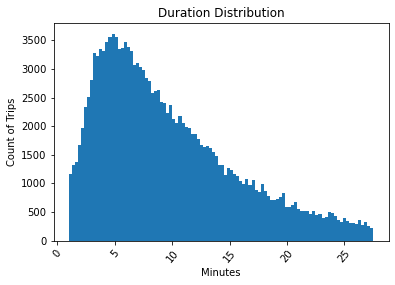

In [54]:
plt.hist(may_trip_adj.minutes, bins = 100)
plt.xticks(rotation=50)
plt.title('Duration Distribution')
plt.xlabel('Minutes')
plt.ylabel('Count of Trips')

Text(0, 0.5, 'Count of Trips')

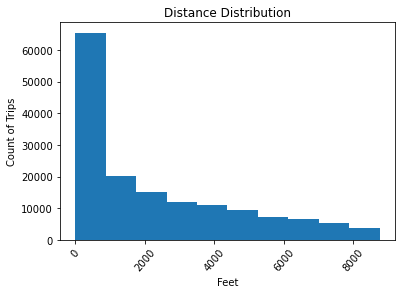

In [55]:
plt.hist(may_trip_adj.tripDistance)
plt.xticks(rotation=50)
plt.title('Distance Distribution')
plt.xlabel('Feet')
plt.ylabel('Count of Trips')

Text(0.5, 1.0, 'Duration v. Distance')

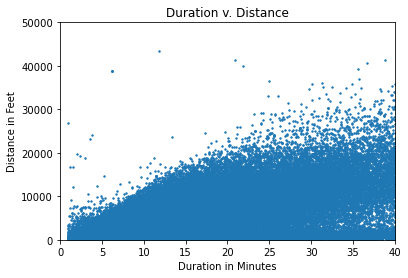

In [56]:
plt.scatter('minutes', 'tripDistance', data = may_trip, s=2)
ax = plt.gca()
ax.set_ylim([0, 50000])
ax.set_xlim([0, 40])
plt.xlabel('Duration in Minutes')
plt.ylabel('Distance in Feet')
plt.title('Duration v. Distance')

Text(0, 0.5, 'Count of Trips')

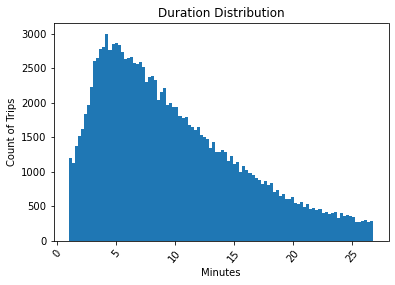

In [57]:
plt.hist(june_trip_adj.minutes, bins = 100)
plt.xticks(rotation=50)
plt.title('Duration Distribution')
plt.xlabel('Minutes')
plt.ylabel('Count of Trips')

Text(0, 0.5, 'Count of Trips')

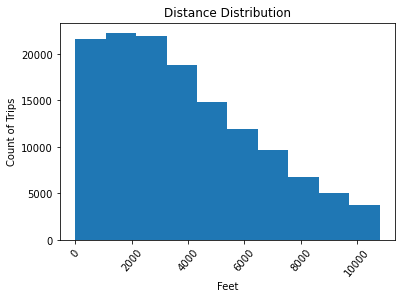

In [58]:
plt.hist(june_trip_adj.tripDistance)
plt.xticks(rotation=50)
plt.title('Distance Distribution')
plt.xlabel('Feet')
plt.ylabel('Count of Trips')

Text(0.5, 1.0, 'Duration v. Distance')

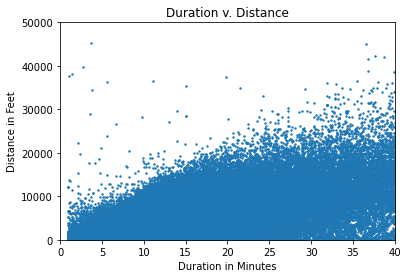

In [59]:
plt.scatter('minutes', 'tripDistance', data = june_trip, s=2)
ax = plt.gca()
ax.set_ylim([0, 50000])
ax.set_xlim([0, 40])
plt.xlabel('Duration in Minutes')
plt.ylabel('Distance in Feet')
plt.title('Duration v. Distance')

Text(0, 0.5, 'Count of Trips')

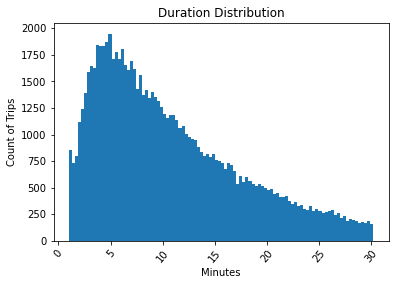

In [60]:
plt.hist(july_trip_adj.minutes, bins = 100)
plt.xticks(rotation=50)
plt.title('Duration Distribution')
plt.xlabel('Minutes')
plt.ylabel('Count of Trips')

Text(0, 0.5, 'Count of Trips')

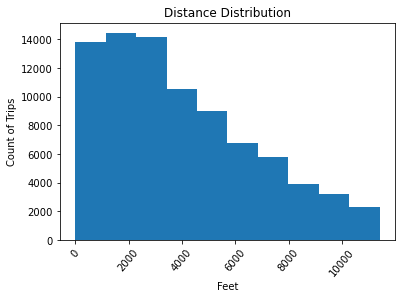

In [61]:
plt.hist(july_trip_adj.tripDistance)
plt.xticks(rotation=50)
plt.title('Distance Distribution')
plt.xlabel('Feet')
plt.ylabel('Count of Trips')

Text(0.5, 1.0, 'Duration v. Distance')

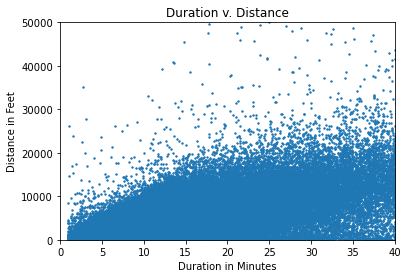

In [62]:
plt.scatter('minutes', 'tripDistance', data = july_trip, s=2)
ax = plt.gca()
ax.set_ylim([0, 50000])
ax.set_xlim([0, 40])
plt.xlabel('Duration in Minutes')
plt.ylabel('Distance in Feet')
plt.title('Duration v. Distance')

In [63]:
may_trip_adj.describe()

,tripDuration,tripDistance,startLatitude,startLongitude,endLatitude,endLongitude,totaltime,seconds,minutes
count,156320.000000,156320.000000,156320.000000,156320.000000,156320.000000,156320.000000,156320,156320.000000,156320.000000
mean,22.524736,2336.396540,36.154780,-86.784007,36.155179,-86.784119,0 days 00:09:41.114500257,581.114500,9.685242
std,102.663723,2346.099949,0.013520,0.013331,0.019613,0.081653,0 days 00:05:59.525777402,359.525777,5.992096
min,1.000000,0.083756,36.044707,-86.918008,32.775953,-117.076117,0 days 00:01:00,60.000000,1.000000
25%,5.000000,389.229600,36.149850,-86.791213,36.150100,-86.791131,0 days 00:04:59,299.000000,4.983333
50%,8.366667,1321.308000,36.156700,-86.781473,36.156980,-86.781495,0 days 00:08:15.278333,495.278333,8.254639
75%,13.633333,3887.748000,36.162592,-86.776290,36.162530,-86.776370,0 days 00:13:11.849999500,791.849999,13.197500
max,1643.000000,8759.840000,36.293024,-86.608901,39.768425,-77.021907,0 days 00:27:31.600000,1651.600000,27.526667


In [64]:
june_trip_adj.describe()

,tripDuration,tripDistance,startLatitude,startLongitude,endLatitude,endLongitude,totaltime,seconds,minutes
count,136802.000000,136802.000000,136802.000000,136802.000000,136802.000000,136802.000000,136802,136802.000000,136802.000000
mean,42.539503,3856.639174,36.156246,-86.784343,36.155957,-86.783951,0 days 00:09:48.669298061,588.669298,9.811155
std,166.496255,2670.400859,0.012018,0.013327,0.203100,0.737427,0 days 00:05:58.904387877,358.904388,5.981740
min,1.000000,0.076653,36.042892,-86.917893,-36.850405,-122.428964,0 days 00:01:00,60.000000,1.000000
25%,5.083333,1686.351760,36.150851,-86.791400,36.150990,-86.791268,0 days 00:05:02,302.000000,5.033333
50%,9.000000,3346.416000,36.157120,-86.782030,36.157500,-86.781608,0 days 00:08:29.493333500,509.493334,8.491556
75%,14.616667,5646.325640,36.163050,-86.776562,36.162970,-86.776501,0 days 00:13:32,812.000000,13.533333
max,1608.000000,10793.832000,36.300029,-86.602127,47.237628,174.764886,0 days 00:26:48.280000,1608.280000,26.804667


In [65]:
july_trip_adj.describe()

,tripDuration,tripDistance,startLatitude,startLongitude,endLatitude,endLongitude,totaltime,seconds,minutes
count,83938.000000,83938.000000,83938.000000,83938.000000,83938.000000,83938.000000,83938,83938.000000,83938.000000
mean,49.830790,3982.494150,36.156872,-86.784813,36.157174,-86.785628,0 days 00:10:41.842311468,641.842311,10.697372
std,194.653320,2829.348474,0.010738,0.013412,0.080469,0.365742,0 days 00:06:51.495679903,411.495680,6.858261
min,1.000000,2.428921,36.037117,-86.890850,27.948352,-122.673729,0 days 00:01:00,60.000000,1.000000
25%,5.187654,1702.756970,36.151170,-86.791940,36.151300,-86.791302,0 days 00:05:12,312.000000,5.200000
50%,9.576408,3375.984360,36.157393,-86.782070,36.157746,-86.781400,0 days 00:09:04.256667,544.256667,9.070944
75%,16.000000,5902.231160,36.162950,-86.776681,36.162733,-86.776589,0 days 00:14:55.276667,895.276667,14.921278
max,1811.000000,11411.393007,36.299569,-86.625443,51.045409,-9.140874,0 days 00:30:11,1811.000000,30.183333
